# Consensus Signatures

A consensus signature can be defined as a perturbation-specific summary profile acquired by aggregating replicate level information.

### - Consensus Datasets

1. Median Aggregation
   - consensus_median (whole plate normalization)
   - consensus_median_dmso (dmso normalization).
   
   
   
   
   
2. Modified Z Score Aggregation (MODZ)
   - consensus_modz (whole plate normalization)
   - consensus_modz_dmso (dmso normalization)

The first approach weights each replicate equally.
The second approach weights replicates by average similarity to other replicates.



### The goal here:
- is to determine the median score of each MOA (Mechanism of action) per dose based on taking the median of the correlation values between compounds of the same MOA.


- is to compute the p-value for each MOA per dose by evaluating the probability of random combinations of compounds (from different MOAs) having greater median correlation score than compounds of the same MOA.

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pycytominer import feature_select
from statistics import median
import random
sns.set_style("darkgrid")
from scipy import stats
import pickle


import warnings

warnings.filterwarnings("ignore", message="Glyph 147 missing from current font.")
warnings.filterwarnings("ignore", message="Glyph 128 missing from current font.")

In [2]:
def feature_selection(dataset_link):
    """
    Perform feature selection by dropping columns with null or 
    only zeros values, and highly correlated values from the data.
    
    params: 
    dataset_link: string of github link to the consensus dataset

    Returns:
    data: returned consensus dataframe
    
    """
    data = pd.read_csv(dataset_link, compression='gzip', error_bad_lines=False)
    cols = data.columns.tolist()
    drop_cols = [x for x in cols if ((data[x].isnull().sum()) | all(y == 0.0 for y in data[x].values))]
    data.drop(drop_cols, axis = 1, inplace = True)
    data = feature_select(data, operation="correlation_threshold")
    return data

In [3]:
consensus_median_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_median.csv.gz?raw=true'
consensus_median_dmso_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_median_dmso.csv.gz?raw=true'
consensus_modz_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_modz.csv.gz?raw=true'
consensus_modz_dmso_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_modz_dmso.csv.gz?raw=true'

In [4]:
data = feature_selection(consensus_modz_link)

In [5]:
data.shape

(10752, 543)

In [ ]:
# ##heatmap -- showing correlation btw features
# plt.rcParams.update({'font.size': 22})
# sns.clustermap(data.corr(), cmap='seismic', figsize=(45, 45)).fig.suptitle('Correlation between Phenotypic measurements columns (features)')

### Mechanism of actions (MOAs)

In [6]:
def merge_moa_data(dataset_link, data):
    
    """
    Merge (mechanism of action) moa dataframe with the consensus dataframe,
    based on distinct broad samples.
    
    params: 
    dataset_link: string of moa_dataset github link
    data: consensus dataframe

    Returns:
    data_moa: merged consensus and moa dataframe with moas
    no_moa_data: merged consensus and moa dataframe without moas
    
    """
    moa_df = pd.read_csv(dataset_link, sep="\t")
    moa_df.drop(['alternative_moa', 'alternative_target'], axis = 1, inplace = True)
    ##append DMSO as row to the moa_df
    dmso = ['DMSO', 'BRD-DMSO', 'DMSO compound', 'DMSO Key', 'DMSO', \
            'DMSO-No Target', 'broad_id_20201014', 'DMSO-No Phase']
    moa_df.loc[len(moa_df)] = dmso
    moa_df.rename(columns={"broad_sample": "Metadata_broad_sample"}, inplace = True)
    data_moa = data.merge(moa_df, on='Metadata_broad_sample', how = 'outer')
    no_moa_data = data_moa[data_moa['moa'].isnull()].copy().reset_index(drop = True)
    data_moa.drop(data_moa['Metadata_broad_sample'][data_moa['moa'].isnull()].index, inplace = True)
    data_moa.reset_index(drop= True, inplace = True)
    
    return data_moa, no_moa_data

In [7]:
moa_dataset = "https://github.com/broadinstitute/lincs-cell-painting/blob/master/metadata/moa/repurposing_info_external_moa_map_resolved.tsv?raw=true"
df_moa, df_no_moa = merge_moa_data(moa_dataset, data)

In [8]:
df_moa.shape

(10440, 550)

In [9]:
df_no_moa.shape

(312, 550)

In [10]:
##list of "Broad samples" WITHOUT Mechanism of Actions --MOA
df_no_moa['Metadata_broad_sample'].unique().tolist()

['BRD-K03842655-001-02-1',
 'BRD-K25837718-001-03-8',
 'BRD-K16508793-001-05-9',
 'BRD-K21547160-001-01-4',
 'BRD-A37288617-003-02-2',
 'BRD-A44448661-001-04-8',
 'BRD-A84045418-001-03-1',
 'BRD-K01192156-001-02-7',
 'BRD-K41438959-001-01-7',
 'BRD-K51033547-003-02-6',
 'BRD-K52080565-001-09-2',
 'BRD-K60623809-001-02-0',
 'BRD-K73395020-001-02-3',
 'BRD-A20131130-001-01-7',
 'BRD-K87278688-001-01-0',
 'BRD-M98279124-300-01-1',
 'BRD-K30563334-001-02-9',
 'BRD-A11990600-001-03-4',
 'BRD-K03816923-001-05-4',
 'BRD-A67373739-001-02-2',
 'BRD-K38183498-001-02-0',
 'BRD-K42417338-045-01-9',
 'BRD-M39350793-334-01-1',
 'BRD-A55393291-001-09-9',
 'BRD-A57382968-001-29-0',
 'BRD-K58626373-003-07-8',
 'BRD-A43331270-001-01-6',
 'BRD-A58280226-312-01-3',
 'BRD-A69951442-001-01-3',
 'BRD-A77216878-001-01-4',
 'BRD-K23875128-001-04-2',
 'BRD-K36324071-363-01-3',
 'BRD-K41895714-001-01-4',
 'BRD-K55013654-003-02-3',
 'BRD-K04887706-375-01-4',
 'BRD-K44876623-001-03-7',
 'BRD-A84174393-236-07-1',
 

### - Get Correlation (using Spearman coefficient)  between compounds for all DOSES (1 - 7).

### - Then, Get the correlation values btw compounds of each particular MOA, and calculate the median from the correlation values and assign it as the "SIZE" of the MOA.

## Recoding Dose Information

The Drug Repurposing Hub collected data on 6 to 7 dose points per compound.
In general, most doses are very near the following 7 dose points (mmoles per liter):

> [0.04, 0.12, 0.37, 1.11, 3.33, 10, 20]

Therefore, to make it easier to filter by dose when comparing compounds, we first align the doses collected in the dataset to their nearest dose point above.
We then recode the dose points into ascending numerical levels and add a new metadata annotation `dose_recode` to the consensus signatures.

| Dose | Dose Recode |
| :--: | :---------: |
| 0 (DMSO) | 0 |
| ~0.04 | 1 |
| ~0.12 | 2 |
| ~0.37 | 3 |
| ~1.11 | 4 |
| ~3.33 | 5 |
| ~10 | 6 |
| ~20 | 7 |

In [11]:
def get_median_moa_size(moa_list, df_dose, df_cpd_agg):
    
    """
    Get the correlation values between compounds of each MOA, 
    then calculate the median of these correlation values 
    and assign it as the "SIZE" of the MOA.
    
    params: 
    moa_list: list of distinct moas for a particular dose
    df_dose: merged consensus and moa dataframe of a partcular dose
    df_dose_corr: merged consensus and moa dataframe of compound correlations of a particular dose

    Returns:
    moa_size: Dict with moa as the keys, and their size as the values
    moa_cpds: Dict with moa as the keys, and the list of moa for each moa as the values
    
    """
    
    moa_cpds = {}
    moa_size = {}
    for moa in moa_list:
        cpds = df_dose['pert_iname'][df_dose['moa'] == moa].unique().tolist()
        moa_cpds[moa] = cpds
        ##taking correlation btw cpds for each MOA
        df_cpds = df_cpd_agg.loc[cpds]
        cpds_corr = df_cpds.T.corr(method = 'spearman').values
        if len(cpds_corr) == 1:
            median_val = 1
        else:
            median_val = median(list(cpds_corr[np.triu_indices(len(cpds_corr), k = 1)]))

        moa_size[moa] = median_val
        
    return moa_size, moa_cpds

In [12]:
def check_moa(moa_size, moa_cpds, df_moa):
    """
    Check if all distinct moas in the moa_consensus dataframe (df_moa) 
    are in moa_size & moa_cpd, if not add them as keys and give them
    a null value as the size for moa_size and also as values for moa_cpds.
    
    params: 
    moa_size: Dict with moa as the keys, and their size as the values
    moa_cpds: Dict with moa as the keys, and the list of moa for each moa as the values
    data_moa: merged consensus and moa df with moas

    Returns:
    moa_size: Dict with moa as the keys, and their size as the values
    moa_cpds: Dict with moa as the keys, and the list of moa for each moa as the values
    
    """
    moa_list = df_moa['moa'].unique().tolist()
    moa_keys = moa_size.keys()
    for moa in moa_list:
        if moa not in moa_keys:
            moa_size[moa] = np.nan
            moa_cpds[moa] = np.nan
    return moa_size, moa_cpds

In [13]:
def get_moasize_df(df_moa):
    
    """
    Generate a dataframe of distinct moas with their sizes and
    corresponding list of compounds for different doses.
    
    params: 
    df_moa: merged consensus and moa dataframe

    Returns:
    df_moa_size: dataframe of distinct moas with their corresponding sizes 
    and list of compounds for all doses.
    
    """
    dose_list = list(set(df_moa['Metadata_dose_recode'].unique().tolist()))[1:]
    
    for dose in dose_list:
        df_dose = df_moa[df_moa['Metadata_dose_recode'] == dose].copy()
        df_cpd_agg = df_dose.groupby(['pert_iname']).agg(['mean'])
        #droplevel
        df_cpd_agg.columns  = df_cpd_agg.columns.droplevel(1)
        df_cpd_agg.rename_axis(None, axis=0, inplace = True)
        df_cpd_agg.drop(['Metadata_mmoles_per_liter', 'Metadata_dose_recode'], axis = 1, inplace = True)
        dose_moa_list = df_dose['moa'].unique().tolist()
        #get the median of the corr values of the cpds for each MOA
        dose_moa_size, dose_moa_cpds = get_median_moa_size(dose_moa_list, df_dose, df_cpd_agg)
        #check if all moa in the df_moa is present in the dose_moa
        dose_moa_size, dose_moa_cpds = check_moa(dose_moa_size, dose_moa_cpds, df_moa)
        sorted_moa_size = {key:value for key, value in sorted(dose_moa_size.items(), key=lambda item: item[0])}
        sorted_dose_cpds = {key:value for key, value in sorted(dose_moa_cpds.items(), key=lambda item: item[0])}
        if dose == 1:
            df_moa_size = pd.DataFrame.from_dict(sorted_moa_size, orient='index', columns = ['dose_1'])
        else:
            df_moa_size['dose_' + str(dose)] = sorted_moa_size.values()
        df_moa_size['moa_cpds_dose_' + str(dose)] = list(sorted_dose_cpds.values())
            
    return df_moa_size

In [14]:
data_moa_size = get_moasize_df(df_moa)

In [15]:
data_moa_size.head(10)

,dose_1,moa_cpds_dose_1,dose_2,moa_cpds_dose_2,dose_3,moa_cpds_dose_3,dose_4,moa_cpds_dose_4,dose_5,moa_cpds_dose_5,dose_6,moa_cpds_dose_6,dose_7,moa_cpds_dose_7
11-beta hydroxysteroid dehydrogenase inhibitor,1.000000,[carbenoxolone],1.000000,[carbenoxolone],1.000000,[carbenoxolone],1.000000,[carbenoxolone],1.000000,[carbenoxolone],1.000000,[carbenoxolone],NaN,NaN
11-beta hydroxysteroid dehydrogenase inhibitor|FXR agonist,1.000000,[chenodeoxycholic-acid],1.000000,[chenodeoxycholic-acid],1.000000,[chenodeoxycholic-acid],1.000000,[chenodeoxycholic-acid],1.000000,[chenodeoxycholic-acid],1.000000,[chenodeoxycholic-acid],NaN,NaN
3-ketoacyl CoA thiolase inhibitor,1.000000,[trimetazidine],1.000000,[trimetazidine],1.000000,[trimetazidine],1.000000,[trimetazidine],1.000000,[trimetazidine],1.000000,[trimetazidine],NaN,NaN
3beta-hydroxy-delta5-steroid dehydrogenase inhibitor,1.000000,[trilostane],1.000000,[trilostane],1.000000,[trilostane],1.000000,[trilostane],1.000000,[trilostane],1.000000,[trilostane],NaN,NaN
5 alpha reductase inhibitor,-0.448908,"[dutasteride, finasteride, acexamic-acid]",-0.470680,"[dutasteride, finasteride, acexamic-acid]",-0.522419,"[dutasteride, finasteride, acexamic-acid]",-0.147489,"[dutasteride, finasteride, acexamic-acid]",0.076114,"[dutasteride, finasteride, acexamic-acid]",0.042146,"[dutasteride, finasteride, acexamic-acid]",NaN,NaN
ACAT inhibitor,-0.276648,"[avasimibe, KD-023, CI-976]",-0.024755,"[avasimibe, KD-023, CI-976]",-0.087220,"[avasimibe, KD-023, CI-976]",-0.304748,"[avasimibe, KD-023, CI-976]",-0.366050,"[avasimibe, KD-023, CI-976]",0.140269,"[avasimibe, KD-023, CI-976]",NaN,NaN
ACAT inhibitor|sterol regulatory element binding protein (SREBP) inhibitor,1.000000,[NSC-4644],1.000000,[NSC-4644],1.000000,[NSC-4644],1.000000,[NSC-4644],1.000000,[NSC-4644],NaN,NaN,NaN,NaN
AGE inhibitor,1.000000,[pirenoxine],1.000000,[pirenoxine],1.000000,[pirenoxine],1.000000,[pirenoxine],1.000000,[pirenoxine],1.000000,[pirenoxine],NaN,NaN
AKT inhibitor,0.013093,"[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...",0.140330,"[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...",0.290898,"[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...",0.364348,"[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...",0.332040,"[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...",0.480906,"[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...",NaN,NaN
AKT inhibitor|TRAIL modulator,1.000000,[TIC10],1.000000,[TIC10],1.000000,[TIC10],1.000000,[TIC10],1.000000,[TIC10],1.000000,[TIC10],NaN,NaN


In [ ]:
#data_moa_size['moa_cpds_dose_7'].values

### - Exclude MOAs with size 1 and only null values and  also columns with only null values

#### The reason why we are excluding MOAs with size/value == 1, is because they have only ONE compound and as a result the medain correlation value will be just 1, and there will not be differences in values btw different doses.

In [16]:
def exclude_moa(df_moa_size):
    """
    Exclude MOAs with size 1.
    
    params: 
    df_moa_size: dataframe of distinct moas with their corresponding sizes 
    and list of compounds for all doses.

    Returns:
    df_moa_medians: dataframe of distinct moas with NO median values/sizes of 1 
    and their corresponding list of compounds for all doses.
    
    """
    moa_with_med_index = []
    for moa in df_moa_size.index.tolist():
        moa_values = df_moa_size.loc[moa]
        if all(y != 1.0 for y in moa_values):
            moa_with_med_index.append(moa)
    df_moa_medians = df_moa_size.loc[moa_with_med_index]
    null_columns = [col for col in df_moa_medians.columns 
                 if all(df_moa_medians[col].isnull())]
    null_moas = [moa for moa in df_moa_medians.index 
                 if all(df_moa_medians.loc[moa].isnull())]
    df_moa_medians.drop(null_columns, axis = 1, inplace = True)
    df_moa_medians.drop(null_moas, axis = 0, inplace = True)
    
    return df_moa_medians

In [17]:
data_moa_medians = exclude_moa(data_moa_size)

In [18]:
##232 MOAs with median values corresponding to correlation btw their cpds
data_moa_medians.shape

(231, 12)

In [19]:
def seperate_cpds_values(df_moa_medians):
    """
    Seperate the list of compunds columns from the values columns in
    moa_median_dataframe
    
    params: 
    df_moa_medians: dataframe of distinct moas with NO median values/sizes of 1 
    and their corresponding list of compounds for all doses.

    Returns:
    df_moa_cpds: dataframe of distinct moas with only their corresponding 
    list of compounds for all doses.
    
    df_moa_values: dataframe of distinct moas with only their sizes for all doses.
    """
    dose_cols = [col for col in df_moa_medians.columns.tolist() 
                 if (col.startswith("dose_"))]
    df_moa_cpds = df_moa_medians.drop(dose_cols, axis = 1)
    df_moa_values = df_moa_medians.loc[:, dose_cols].copy()
    
    return df_moa_cpds, df_moa_values

In [20]:
data_moa_cpds, data_moa_values = seperate_cpds_values(data_moa_medians)

In [21]:
data_moa_cpds.head()

,moa_cpds_dose_1,moa_cpds_dose_2,moa_cpds_dose_3,moa_cpds_dose_4,moa_cpds_dose_5,moa_cpds_dose_6
5 alpha reductase inhibitor,"[dutasteride, finasteride, acexamic-acid]","[dutasteride, finasteride, acexamic-acid]","[dutasteride, finasteride, acexamic-acid]","[dutasteride, finasteride, acexamic-acid]","[dutasteride, finasteride, acexamic-acid]","[dutasteride, finasteride, acexamic-acid]"
ACAT inhibitor,"[avasimibe, KD-023, CI-976]","[avasimibe, KD-023, CI-976]","[avasimibe, KD-023, CI-976]","[avasimibe, KD-023, CI-976]","[avasimibe, KD-023, CI-976]","[avasimibe, KD-023, CI-976]"
AKT inhibitor,"[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...","[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...","[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...","[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...","[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...","[10-DEBC, GSK2110183, GDC-0068, MK-2206, honok..."
ALK tyrosine kinase receptor inhibitor,"[alectinib, AP26113, CEP-37440, crizotinib]","[alectinib, AP26113, CEP-37440, crizotinib]","[alectinib, AP26113, CEP-37440, crizotinib]","[alectinib, AP26113, CEP-37440, crizotinib]","[alectinib, AP26113, CEP-37440, crizotinib]","[alectinib, AP26113, CEP-37440, crizotinib]"
ATP channel blocker,"[tolazamide, tolbutamide, chlorpropamide]","[tolazamide, tolbutamide, chlorpropamide]","[tolazamide, tolbutamide, chlorpropamide]","[tolazamide, tolbutamide, chlorpropamide]","[tolazamide, tolbutamide, chlorpropamide]","[tolazamide, tolbutamide, chlorpropamide]"


### - Check if the MOAs have the same compounds in all the Doses

In [22]:
def check_moas_cpds_doses(df_moa_cpds):
    """
    check if moas have the same compounds in all doses,
    and return the moas that don't have the same numbers of compounds.
    
    params: 
    df_moa_cpds: dataframe of distinct moas with only their corresponding 
    list of compounds for all doses.

    Returns:
    df_moa_not_equals_cpds: dataframe of moas that don't have the same numbers of 
    compounds in all doses.
    
    """
    moas_with_no_equal_cpds = [moa for moa in df_moa_cpds.index 
                               for num in range(len(df_moa_cpds.columns) - 1) 
                               if not ((df_moa_cpds.loc[moa, df_moa_cpds.columns[num]]) 
                                       == (df_moa_cpds.loc[moa, df_moa_cpds.columns[num+1]]))]
    df_moa_not_equals_cpds = df_moa_cpds.loc[set(moas_with_no_equal_cpds)]
    
    return df_moa_not_equals_cpds

In [23]:
data_moa_not_equals_cpds = check_moas_cpds_doses(data_moa_cpds) ##MOAs with not the same cpds in all doses

### - MOAS that do not have the same number of compounds in all Doses

In [24]:
for moa in data_moa_not_equals_cpds.index:
    print(moa)
    for idx, cols in enumerate(data_moa_not_equals_cpds.columns):
        print('Dose ' + str(idx+1) +':', data_moa_cpds.loc[moa, cols])
    print('\n')

neurotrophic agent
Dose 1: ['inosine', 'PYM50028', 'NSI-189']
Dose 2: ['inosine', 'PYM50028', 'NSI-189']
Dose 3: ['inosine', 'PYM50028', 'NSI-189']
Dose 4: ['inosine', 'PYM50028', 'NSI-189']
Dose 5: ['inosine', 'PYM50028', 'NSI-189']
Dose 6: ['inosine', 'NSI-189']


prostanoid receptor agonist
Dose 1: ['travoprost', 'latanoprost', 'alprostadil', 'bimatoprost', '16,16-dimethylprostaglandin-e2']
Dose 2: ['travoprost', 'latanoprost', 'alprostadil', 'bimatoprost', '16,16-dimethylprostaglandin-e2']
Dose 3: ['travoprost', 'latanoprost', 'alprostadil', 'bimatoprost', '16,16-dimethylprostaglandin-e2']
Dose 4: ['travoprost', 'latanoprost', 'alprostadil', 'bimatoprost', '16,16-dimethylprostaglandin-e2']
Dose 5: ['travoprost', 'latanoprost', 'alprostadil', 'bimatoprost']
Dose 6: ['travoprost', 'latanoprost', 'alprostadil', 'bimatoprost']


PKC inhibitor
Dose 1: ['sotrastaurin', 'GF109203X', 'ethylenediaminetetraacetic-acid', 'enzastaurin', 'dequalinium', 'safingol']
Dose 2: ['sotrastaurin', 'GF10

### - MOAS with their sizes for all doses

In [25]:
data_moa_values.head(20)

,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6
5 alpha reductase inhibitor,-0.448908,-0.470680,-0.522419,-0.147489,0.076114,0.042146
ACAT inhibitor,-0.276648,-0.024755,-0.087220,-0.304748,-0.366050,0.140269
AKT inhibitor,0.013093,0.140330,0.290898,0.364348,0.332040,0.480906
ALK tyrosine kinase receptor inhibitor,0.160020,0.123735,0.086779,0.153281,0.460900,0.497310
ATP channel blocker,0.037594,0.211673,-0.132461,-0.367358,-0.097064,-0.024442
ATPase inhibitor,-0.094904,0.051762,-0.035901,0.013374,-0.049322,-0.068592
Aurora kinase inhibitor,0.126551,0.632815,0.788639,0.878721,0.913375,0.802861
BCL inhibitor,0.032420,0.335305,0.150176,0.434719,0.351709,0.443506
Bcr-Abl kinase inhibitor,-0.629138,-0.458843,-0.101452,-0.124481,-0.209334,0.347677
Bruton's tyrosine kinase (BTK) inhibitor,-0.029050,0.027225,0.014560,0.108393,0.357255,0.366992


In [26]:
def save_to_csv(df, path, file_name):
    """saves moa dataframes to csv"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    df.to_csv(os.path.join(path, file_name))

In [27]:
save_to_csv(data_moa_values, 'moa_sizes_consensus_datasets', 'modz_moa_median_scores.csv')

In [28]:
def plot_save_heatmap(df_moa_values, file_name):
    """Generate and save heatmap plot for the moa sizes dataframe based on different doses"""
    
    if not os.path.exists('consensus_imgs'):
        os.mkdir('consensus_imgs')
        
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(45,45)) 
    plt.title("Variation in MOA sizes across different doses")
    sns.heatmap(df_moa_values, cmap='Reds')
    plt.savefig(os.path.join('consensus_imgs', file_name))
    plt.show()

### - Split the dataframe into 3 parts for easier visualization - Example

### - Plots - variation in MOA sizes across different doses

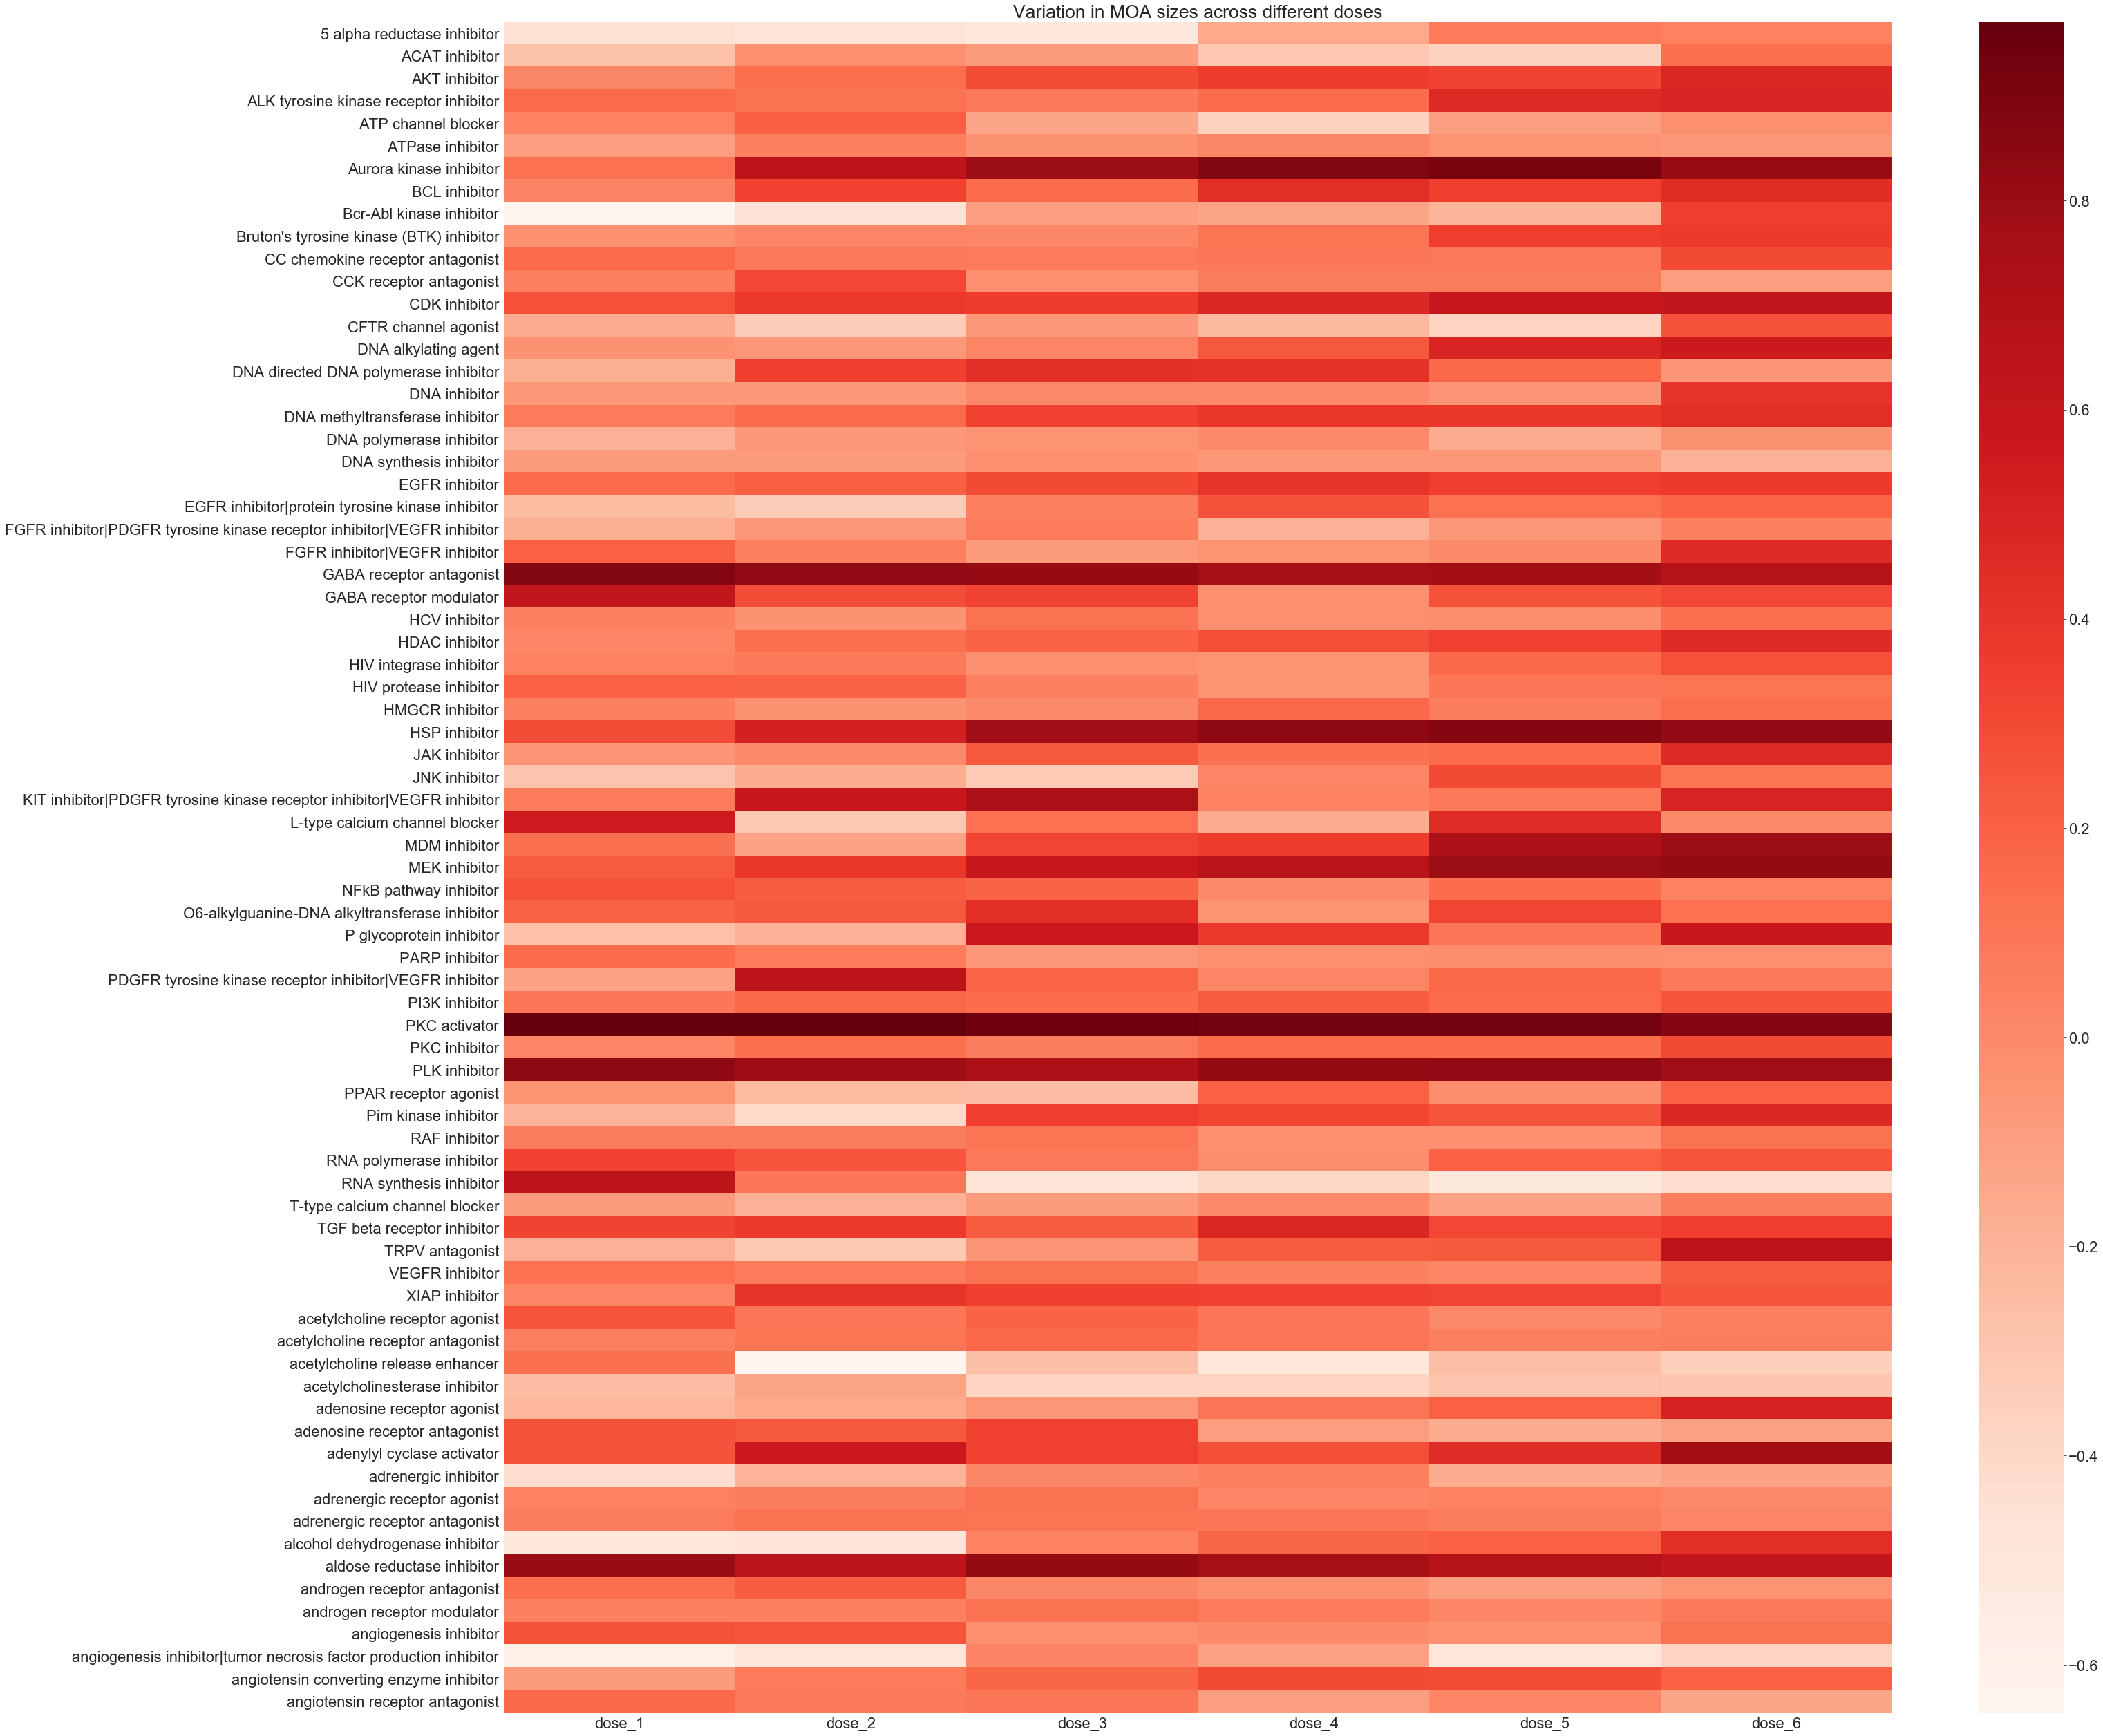

In [29]:
plot_save_heatmap(data_moa_values.iloc[:75, :], 'modz_heatmap_1.png')

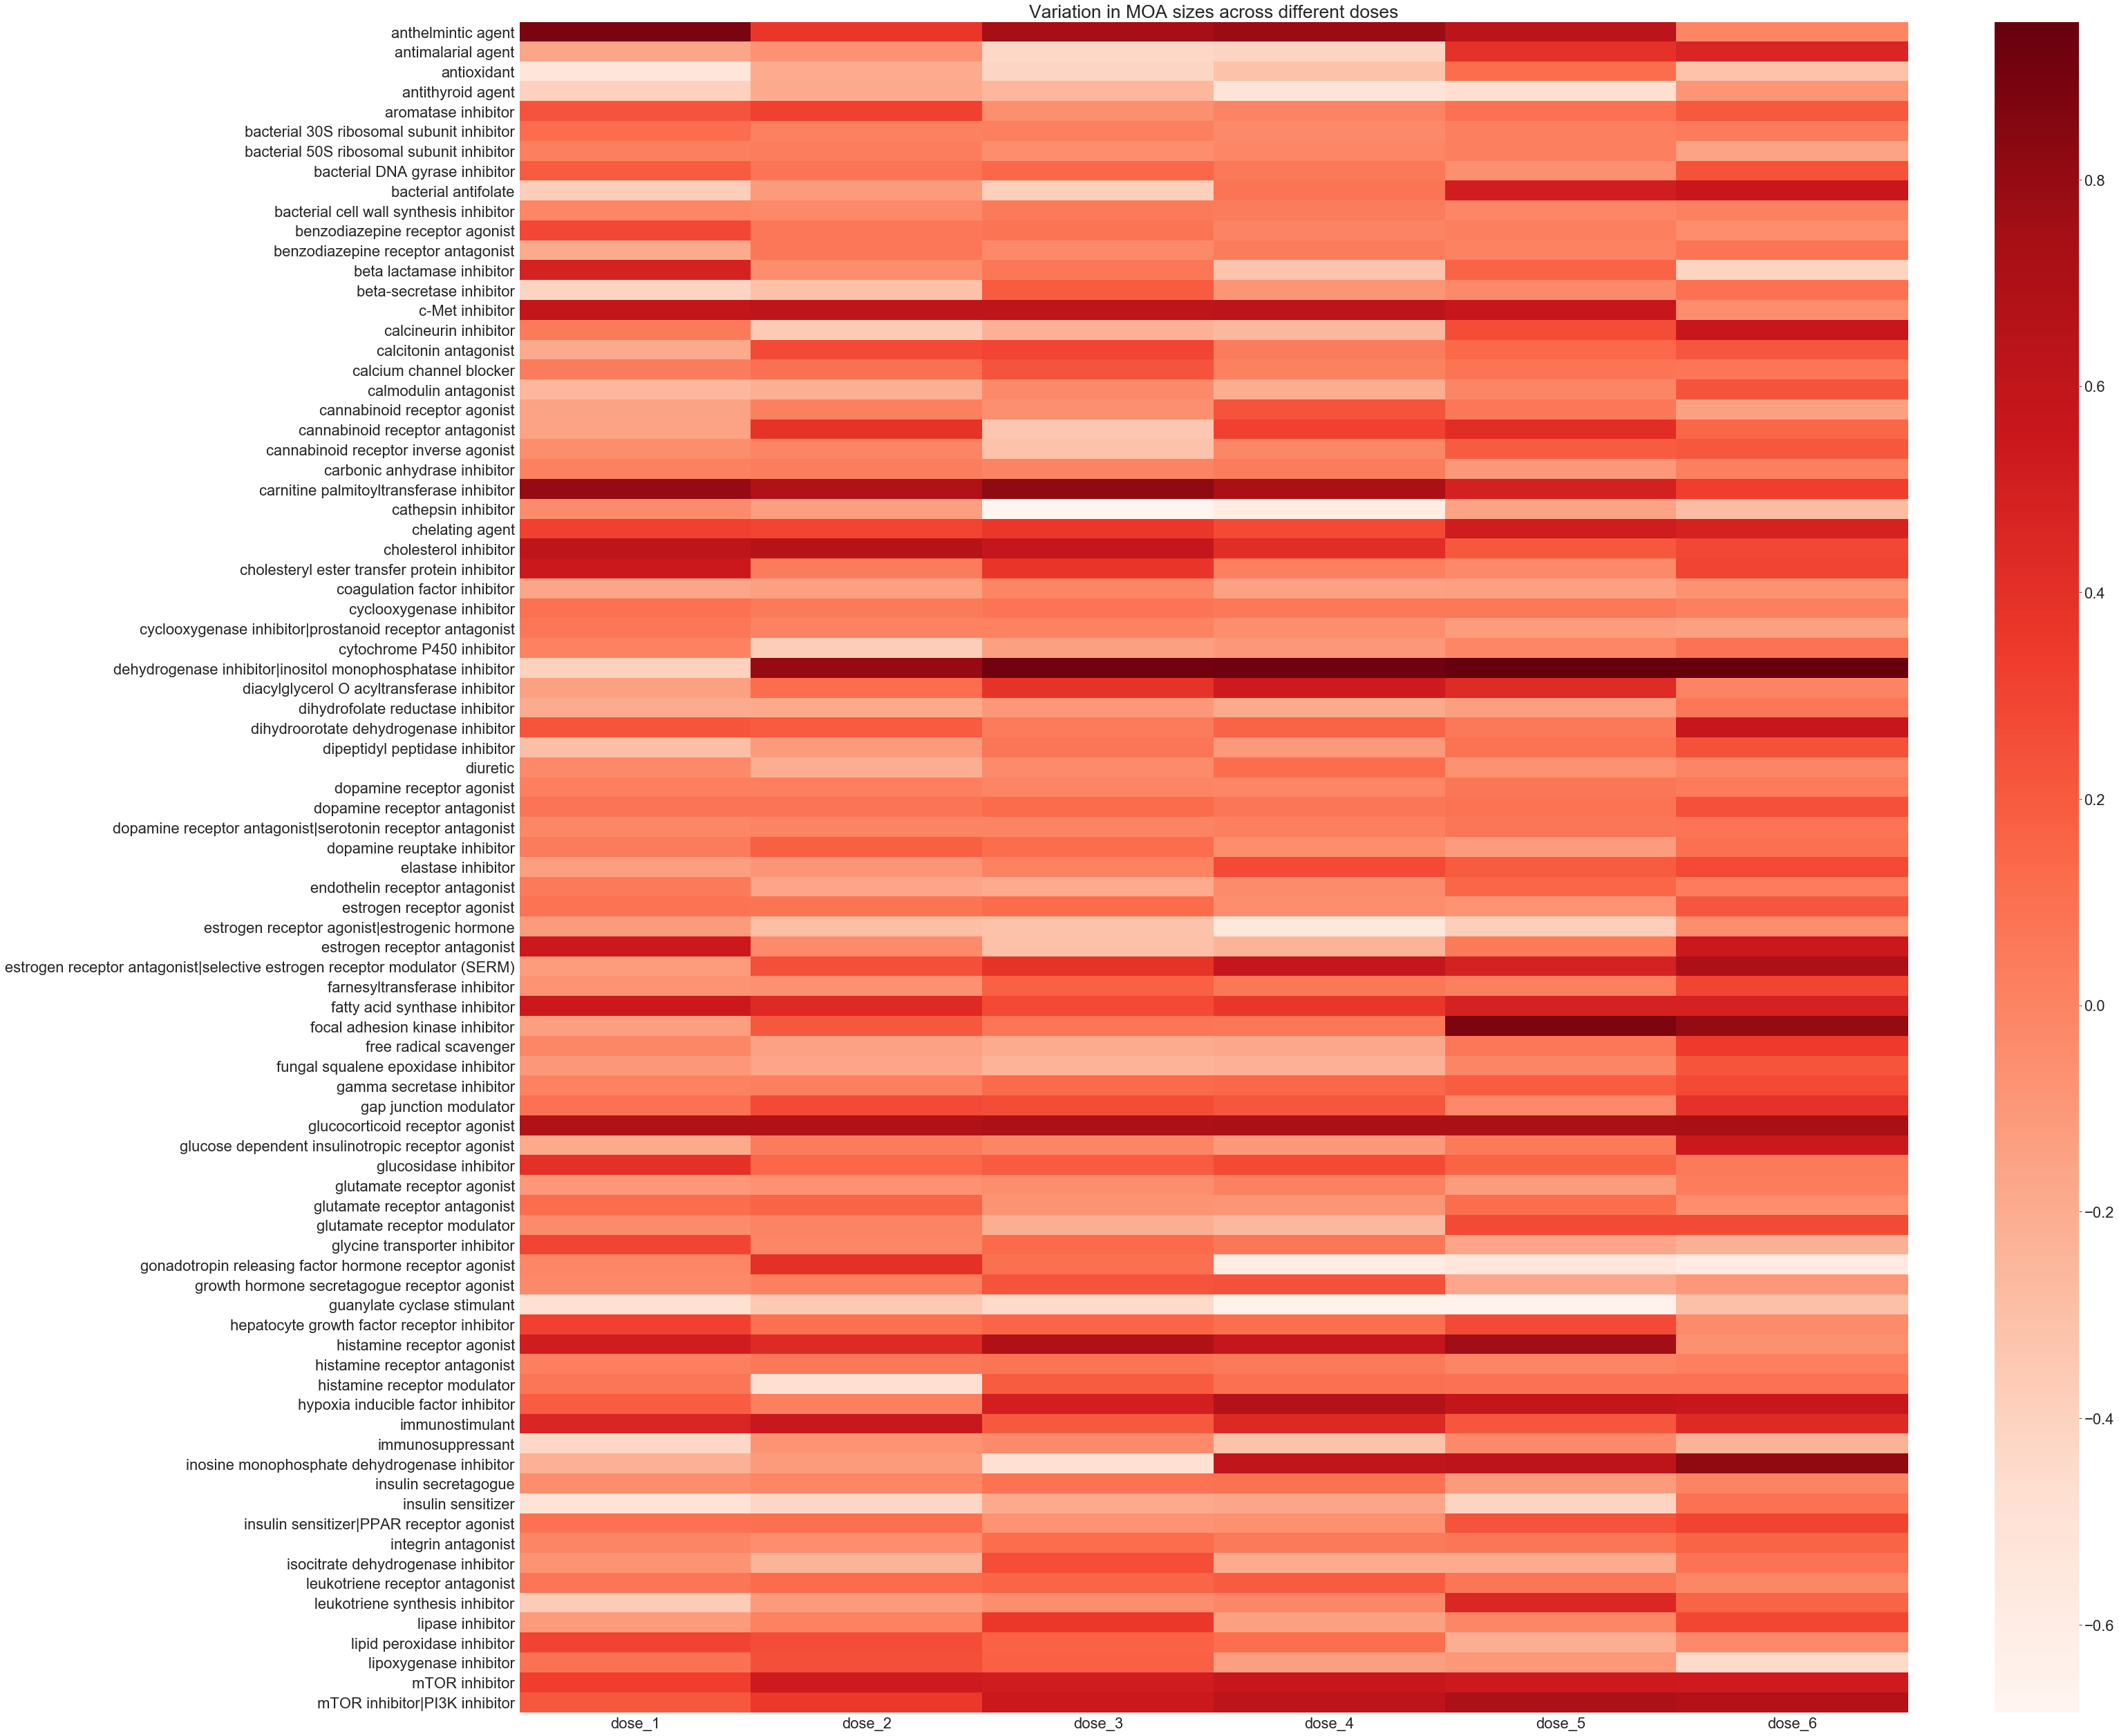

In [30]:
plot_save_heatmap(data_moa_values.iloc[75:160, :], 'modz_heatmap_2.png')

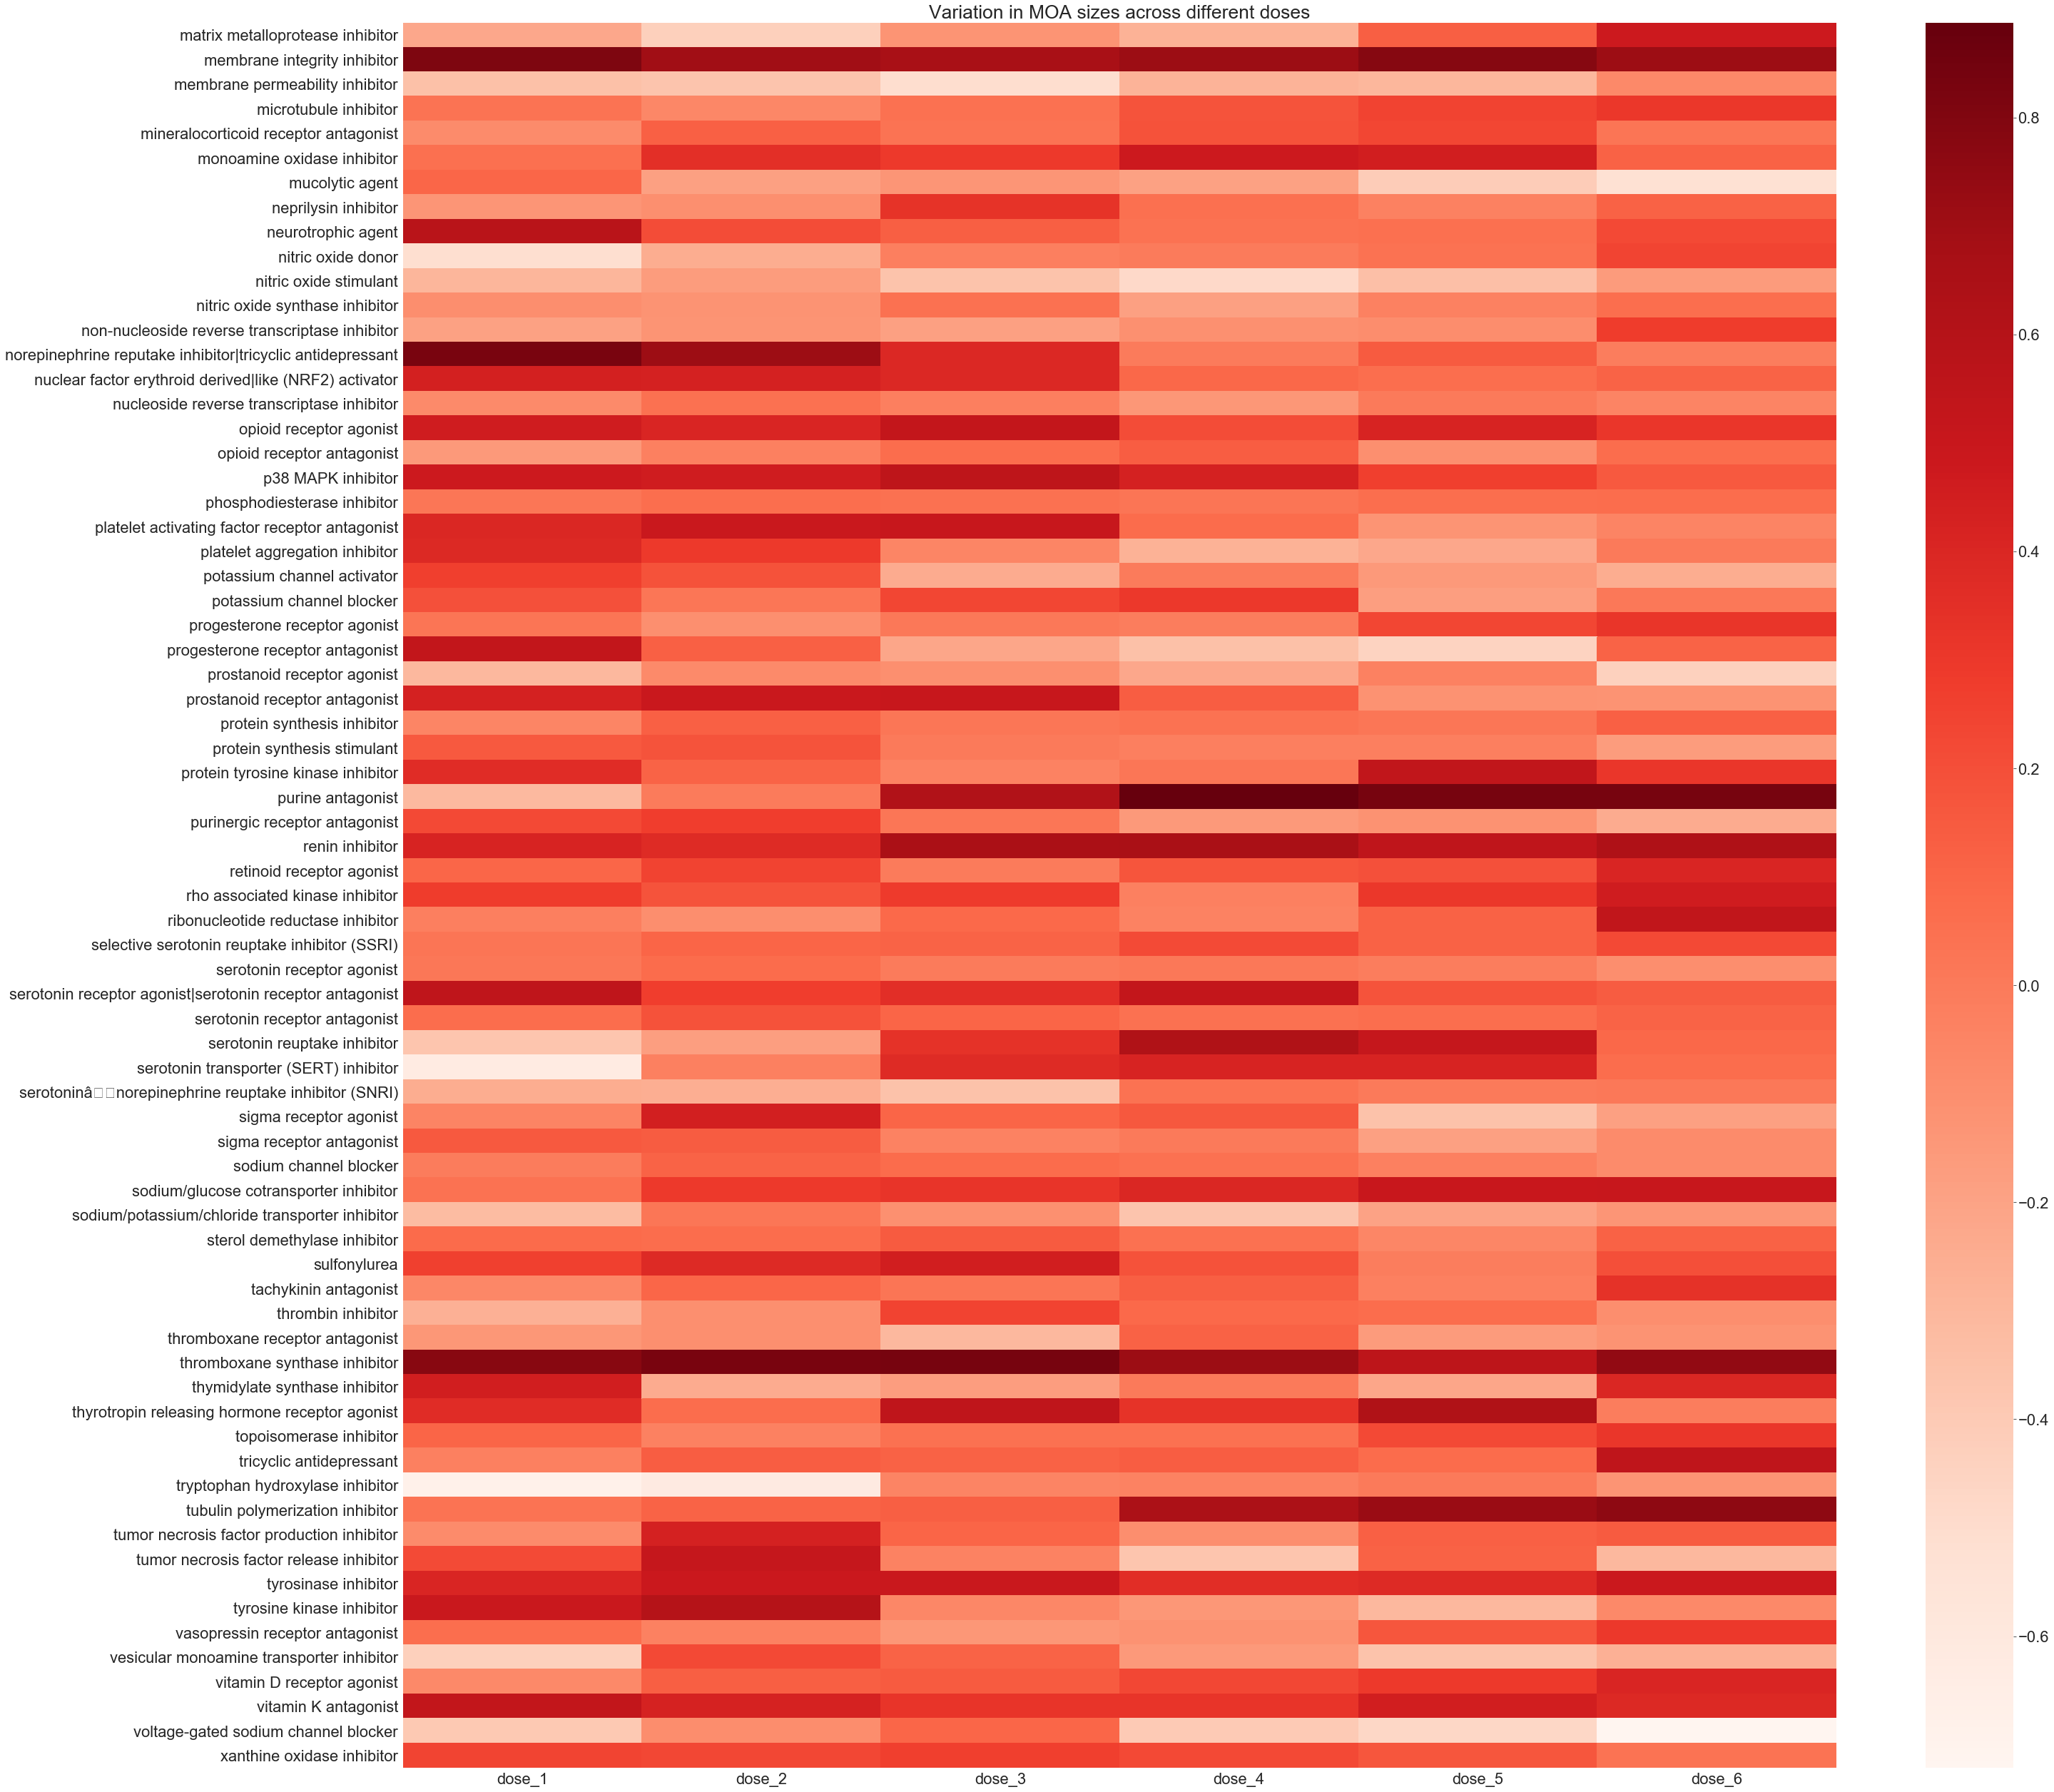

In [31]:
plot_save_heatmap(data_moa_values.iloc[160:, :], 'modz_heatmap_3.png')

In [ ]:
#data_moa_cpds

### - Note the first part of the analysis (i.e. obtaining median correlation scores for each MOA per dose) ends here, I also only showed the Modz consensus data results, but I did this analysis for all the 4 consensus data.

- two dataframes ouput from the above analysis (df_moa and data_moa_values) are used for the next analysis(null distribution) for all 4 consensus data.

## - Calculating Null Distribution

- Null distribution - is generated by getting the median correlation score of randomly combined compounds that do not share/come from the same MOAs.



- In our case, we generated 1000 median correlation scores from randomly combined compounds as the **null distribution** for each MOA.

In [32]:
def get_cpd_agg(data_moa, dose_number):
    """
    This function aggregate values for a particular 
    dose by taking the mean value of distinct compounds in the dose
    """
    
    df_dose = data_moa[data_moa['Metadata_dose_recode'] == dose_number].copy()
    meta_cols = [col for col in df_dose.columns.tolist() 
                 if (col.startswith("Metadata_"))]
    df_dose.drop(meta_cols, axis = 1, inplace = True)
    df_compound_agg = df_dose.groupby(['pert_iname']).agg(['mean'])
    df_compound_agg.columns  = df_compound_agg.columns.droplevel(1)
    df_compound_agg.rename_axis(None, axis=0, inplace = True)
    
    return df_compound_agg

In [35]:
df_cpd_agg = get_cpd_agg(df_moa, 1)

In [33]:
def cpds_found_in_all_doses(data_moa, df_cpd_agg):
    """This function return a list of compounds found in all doses (1 - 6)"""
    cpds_fd = []
    for num in range(1,7):
        df_cpd_agg = get_cpd_agg(data_moa, num)
        all_cpds = df_cpd_agg.index.tolist()
        cpds_fd.append(all_cpds)
    
    cpds_fd_in_all = [cpd for list_cpds in cpds_fd 
                      for cpd in list_cpds 
                      if all(cpd in list_of_cpds for list_of_cpds in cpds_fd)]
    cpds_fd_in_all = list(set(cpds_fd_in_all))
    
    return cpds_fd_in_all

In [36]:
cpds_fd_in_all = cpds_found_in_all_doses(df_moa, df_cpd_agg)

In [37]:
len(cpds_fd_in_all)

1500

In [38]:
all_moa_list = df_moa['moa'].unique().tolist()

In [39]:
len(all_moa_list)

602

In [40]:
all_moa_dict = {moa: [cpd for cpd in df_moa['pert_iname'][df_moa['moa']== moa].unique().tolist() 
                      if cpd in cpds_fd_in_all]
                for moa in all_moa_list}

In [ ]:
#all_moa_dict

In [41]:
def check_similar_cpds(cpds, moa_dict):
    """This function checks if two compounds are found in the same moa"""
    
    for x in range(len(cpds)):
        for y in range(x+1, len(cpds)):
            for kys in moa_dict:
                if all(i in moa_dict[kys] for i in [cpds[x], cpds[y]]):
                    return True
    return False

In [42]:
def get_random_cpds(all_cpds, moa_cpds, all_moa_cpds):
    """
    This function return a list of random cpds that are not of the same moas 
    or found in the current moa cpd's list
    """
    while (True):
        random_cpds = random.sample(all_cpds, len(moa_cpds))
        if not (any(cpds in moa_cpds for cpds in random_cpds) & (check_similar_cpds(random_cpds, all_moa_cpds))):
            break
    return random_cpds

#### - You only need to generate the null distribution once, since the 1000 lists of randomly generated compounds combinations  for each MOA are found in all doses and all consensus datasets

In [43]:
def get_null_distribution_cpds(df_moa_cpds, cpds_list, all_moa_dict, rand_num = 1000):
    
    """This function returns the null distribution dictionary, with MOAs as the keys and 
    1000 lists of randomly selected compounds combinations as the values for each MOA"""
    
    null_distribution_moa = {}
    for moa in df_moa_cpds.index.tolist():
        moa_cpds = df_moa_cpds.loc[moa][0] 
        moa_cpds_list = []
        for idx in range(rand_num):
            start_again = True
            while (start_again):
                rand_cpds = get_random_cpds(cpds_list, moa_cpds, all_moa_dict)
                if rand_cpds not in moa_cpds_list:
                    start_again = False
            moa_cpds_list.append(rand_cpds)
        null_distribution_moa[moa] = moa_cpds_list
    
    return null_distribution_moa

In [ ]:
null_distribution_moa = get_null_distribution_cpds(data_moa_cpds, cpds_fd_in_all, all_moa_dict)

In [ ]:
##save the null_distribution_moa to pickle, you only need to run the code once
with open('null_distribution.pickle', 'wb') as handle:
    pickle.dump(null_distribution_moa, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
##load the null_distribution_moa from pickle
with open('null_distribution.pickle', 'rb') as handle:
    null_distribution_moa = pickle.load(handle)

In [ ]:
len(null_distribution_moa)

In [ ]:
def assert_null_distribution(null_distribution_moa):
    
    """
    This function assert that each of the list in the 1000 lists of 
    random compounds combination for each MOA are distinct with no duplicates
    """
    
    duplicates_moa = {}
    for keys in null_distribution_moa:
        null_dist = null_distribution_moa[keys]
        for cpds_moa in null_dist:
            cpds_duplicates = []
            new_list = list(filter(lambda cpds_list: cpds_list != cpds_moa, null_dist))
            if (len(new_list) != len(null_dist) - 1):
                cpds_duplicates.append(cpds_moa)
        if cpds_duplicates:
            duplicates_moa[keys] = cpds_duplicates
    return duplicates_moa

In [ ]:
duplicates_cpds_list = assert_null_distribution(null_distribution_moa)

In [ ]:
duplicates_cpds_list ##no duplicate found

In [ ]:
def get_null_dist_median_scores(data_moa, dose_num, moa_cpds_list):
    """
    This function calculate the median of the correlation 
    values for each of the list in the 1000 lists of 
    random compounds combination for each MOA
    """
    df_cpd_agg = get_cpd_agg(data_moa, dose_num)
    median_corr_list = []
    for list_of_cpds in moa_cpds_list:
        df_cpds = df_cpd_agg.loc[list_of_cpds]
        cpds_corr = df_cpds.T.corr(method = 'spearman').values
        median_corr_val = median(list(cpds_corr[np.triu_indices(len(cpds_corr), k = 1)]))
        median_corr_list.append(median_corr_val)
    return median_corr_list

**A P value can be computed nonparametrically by evaluating the probability of random compounds of different MOAs having greater median similarity value than compounds of the same MOAs.**

In [ ]:
def get_p_value(median_scores_list, df_moa_values, dose_name, moa_name):
    """
    This function calculate the p-value from the 
    null_distribution median scores for each MOA
    """
    actual_med = df_moa_values.loc[moa_name, dose_name]
    p_value = np.sum(median_scores_list >= actual_med) / len(median_scores_list)
    return p_value

In [ ]:
def get_moa_p_vals(null_dist_moa, data_moa, data_moa_values):
    """
    This function returns a dict, with MOAs as the keys and the MOA's 
    p-values for each dose (1-6) as the values
    """
    null_p_vals = {}
    for moa in null_dist_moa:
        dose_p_values = []
        for num in range(1,7):
            moa_median_scores = get_null_dist_median_scores(data_moa, num, null_distribution_moa[moa])
            dose_name = 'dose_' + str(num)
            moa_p_value = get_p_value(moa_median_scores, data_moa_values, dose_name, moa)
            dose_p_values.append(moa_p_value)
        null_p_vals[moa] = dose_p_values
    return null_p_vals

In [ ]:
#null_p_vals = get_moa_p_vals(null_distribution_moa, df_moa, data_moa_values)

In [ ]:
len(null_p_vals)

In [ ]:
df_null_p_vals = pd.DataFrame.from_dict(null_p_vals, orient='index', columns = ['dose_' + str(x) for x in range(1,7)])

In [ ]:
#df_null_p_vals.head(20)

In [ ]:
save_to_csv(df_null_p_vals, 'moa_sizes_consensus_datasets', 'median_null_p_values.csv')

#### - I didnt run the the null distribution code cells because I had already ran it for all (4) consensus data, and it take several minutes to generate the p_values from the null distribution for each consensus data.

### - Visualization of p-values vs median scores for each MOAs per dose

In [44]:
def read_from_csv(median_file_name, p_value_file_name):
    """
    The function return p_values and median scores 
    dataframes for each MOA for all doses(1-6)
    """
    df_null = pd.read_csv(os.path.join('moa_sizes_consensus_datasets', p_value_file_name), index_col=0)
    df_moa_values = pd.read_csv(os.path.join('moa_sizes_consensus_datasets', median_file_name), index_col=0)
    return df_null, df_moa_values

In [45]:
def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: MOA, dose number and dose_values(median score or p-value)
    """
    df = df.reset_index().rename(columns={"index": "MOAs"})
    df = df.melt(id_vars=['MOAs'], var_name="Dose", value_name=col_name)
    return df

In [46]:
def merge_p_median_vals(median_file_name, p_value_file_name):
    """
    This function merge p_values and median scores 
    dataframes for each MOA for all doses(1-6) 
    """
    
    df_null, df_moa_vals = read_from_csv(median_file_name, p_value_file_name)
    df_p_vals = melt_df(df_null, 'p_values')
    df_moa_vals = melt_df(df_moa_vals, 'median_scores')
    df_moa_vals['p_values'] = df_p_vals['p_values']
    return df_moa_vals

In [69]:
def stat_significant_MOAs(median_file_name, p_value_file_name):
    """
    This function return MOAs with less than (0.05) 5% probability of 
    obtaining median correlation score from the null distribution that is 
    greater than or equal to their own median correlation score all doses(1-6)
    """
    df_p_values, _ = read_from_csv(median_file_name, p_value_file_name)
    p_moas = [moa for moa in df_p_values.index 
                 if all(df_p_values.loc[moa].values < 0.05)]
    return df_p_values.loc[p_moas]

In [50]:
def plot_p_vs_median(df, text):
    """plot p_values vs median correlation scores for each MOA for all doses"""
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel("Median scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric P-values")
    plt.title("P-values vs Median scores for " + text)
    fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="Dose", style="Dose")
    fig.axhline(0.05, ls='--', c='black')
    fig.text(-0.70,0.07, "Significance level (0.05)")
    plt.show()

### - Median Consensus

In [47]:
df_moas_values = merge_p_median_vals('median_moa_median_scores.csv', 'median_null_p_values.csv')

In [48]:
df_moas_values.head()

,MOAs,Dose,median_scores,p_values
0,5 alpha reductase inhibitor,dose_1,-0.346371,0.922
1,ACAT inhibitor,dose_1,-0.243530,0.804
2,AKT inhibitor,dose_1,0.055085,0.351
3,ALK tyrosine kinase receptor inhibitor,dose_1,0.115106,0.239
4,ATP channel blocker,dose_1,-0.012127,0.459


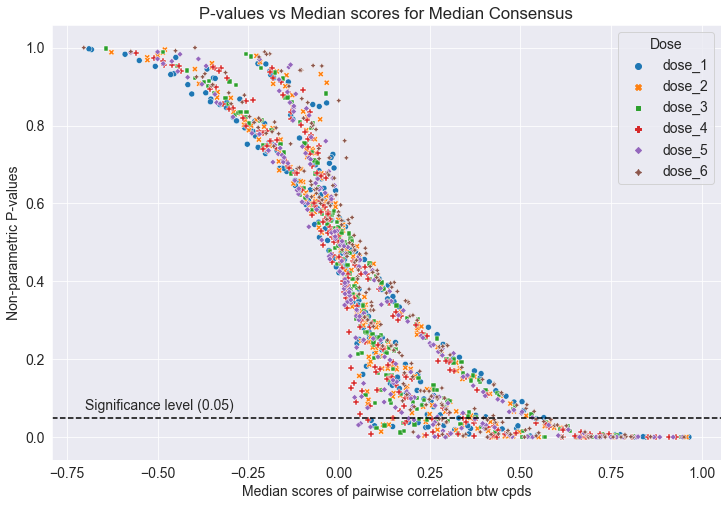

In [51]:
plot_p_vs_median(df_moas_values, 'Median Consensus')

- MOAs with less than (0.05) 5% probability of obtaining median correlation score from the null distribution that is greater than or equal to their own median correlation score **assuming** median score generated from randomly selected cpds of different moas are greater than those of the same MOAs.

In [65]:
stat_significant_MOAs('median_moa_median_scores.csv', 'median_null_p_values.csv')

,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6
CDK inhibitor,0.037,0.004,0.009,0.000,0.000,0.000
EGFR inhibitor,0.027,0.004,0.000,0.000,0.000,0.003
GABA receptor antagonist,0.000,0.000,0.002,0.007,0.000,0.029
HSP inhibitor,0.019,0.002,0.000,0.000,0.000,0.000
MEK inhibitor,0.025,0.000,0.000,0.000,0.000,0.000
PKC activator,0.000,0.000,0.000,0.000,0.000,0.001
PLK inhibitor,0.000,0.000,0.000,0.000,0.000,0.000
aldose reductase inhibitor,0.006,0.036,0.004,0.007,0.010,0.031
chelating agent,0.049,0.030,0.034,0.046,0.005,0.017
glucocorticoid receptor agonist,0.000,0.000,0.000,0.000,0.000,0.000


### - Median_DMSO Consensus

In [52]:
df_med_dmso_vals = merge_p_median_vals('median_dmso_moa_median_scores.csv', 'median_dmso_null_p_values.csv')

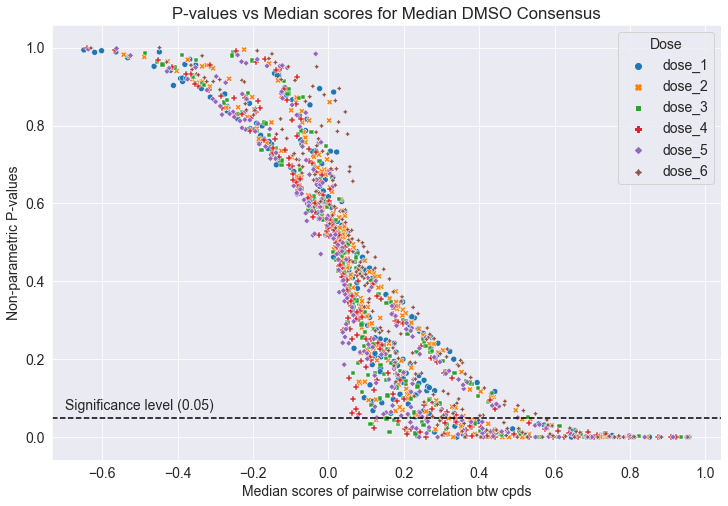

In [53]:
plot_p_vs_median(df_med_dmso_vals, 'Median DMSO Consensus')

In [66]:
##MOAs whose p-values are <0.05
stat_significant_MOAs('median_dmso_moa_median_scores.csv', 'median_dmso_null_p_values.csv')

,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6
CDK inhibitor,0.013,0.000,0.000,0.000,0.000,0.000
EGFR inhibitor,0.003,0.000,0.000,0.000,0.000,0.000
GABA receptor antagonist,0.000,0.000,0.003,0.007,0.000,0.044
MEK inhibitor,0.000,0.000,0.000,0.000,0.000,0.000
PKC activator,0.000,0.000,0.000,0.000,0.000,0.000
PLK inhibitor,0.000,0.000,0.000,0.000,0.000,0.000
glucocorticoid receptor agonist,0.000,0.000,0.000,0.000,0.000,0.000
mTOR inhibitor,0.008,0.000,0.000,0.000,0.000,0.000
membrane integrity inhibitor,0.005,0.030,0.009,0.001,0.002,0.023
thromboxane synthase inhibitor,0.000,0.001,0.000,0.002,0.012,0.008


### - Modz consensus

In [54]:
df_modz_vals = merge_p_median_vals('modz_moa_median_scores.csv', 'modz_null_p_values.csv')

In [55]:
df_modz_vals.head()

,MOAs,Dose,median_scores,p_values
0,5 alpha reductase inhibitor,dose_1,-0.448908,0.963
1,ACAT inhibitor,dose_1,-0.276648,0.831
2,AKT inhibitor,dose_1,0.013093,0.467
3,ALK tyrosine kinase receptor inhibitor,dose_1,0.160020,0.196
4,ATP channel blocker,dose_1,0.037594,0.389


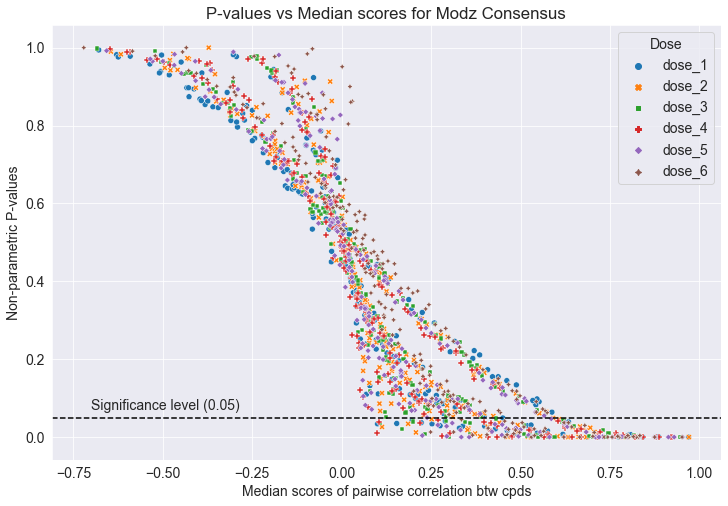

In [56]:
plot_p_vs_median(df_modz_vals, 'Modz Consensus')

In [67]:
##MOAS whose p-values < 0.05
stat_significant_MOAs('modz_moa_median_scores.csv', 'modz_null_p_values.csv')

,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6
CDK inhibitor,0.029,0.009,0.007,0.000,0.000,0.000
EGFR inhibitor,0.035,0.012,0.000,0.000,0.000,0.005
GABA receptor antagonist,0.001,0.001,0.005,0.011,0.003,0.030
HSP inhibitor,0.041,0.001,0.000,0.000,0.000,0.000
MEK inhibitor,0.037,0.002,0.000,0.000,0.000,0.000
PKC activator,0.000,0.000,0.000,0.000,0.000,0.000
PLK inhibitor,0.000,0.000,0.000,0.000,0.000,0.000
aldose reductase inhibitor,0.006,0.027,0.003,0.004,0.013,0.037
glucocorticoid receptor agonist,0.000,0.000,0.000,0.000,0.000,0.000
mTOR inhibitor,0.023,0.000,0.003,0.000,0.001,0.000


### Modz DMSO Consensus

In [57]:
df_modz_dmso_vals = merge_p_median_vals('modz_dmso_moa_median_scores.csv', 'modz_dmso_null_p_values.csv')

In [58]:
df_modz_dmso_vals.head()

,MOAs,Dose,median_scores,p_values
0,5 alpha reductase inhibitor,dose_1,-0.459845,0.982
1,ACAT inhibitor,dose_1,-0.162153,0.746
2,AKT inhibitor,dose_1,0.036155,0.507
3,ALK tyrosine kinase receptor inhibitor,dose_1,0.265592,0.092
4,ATP channel blocker,dose_1,-0.003598,0.499


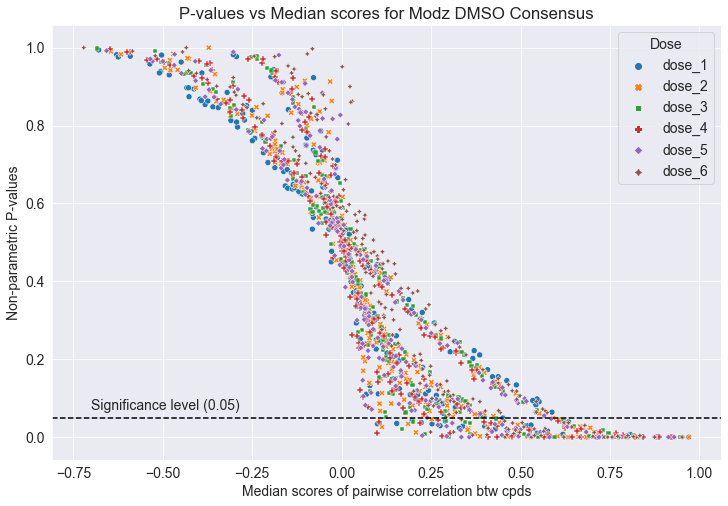

In [59]:
plot_p_vs_median(df_modz_vals, 'Modz DMSO Consensus')

In [68]:
##MOAS whose p-values < 0.05
stat_significant_MOAs('modz_dmso_moa_median_scores.csv', 'modz_dmso_null_p_values.csv')

,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6
CDK inhibitor,0.008,0.000,0.001,0.000,0.000,0.000
EGFR inhibitor,0.003,0.001,0.000,0.000,0.000,0.003
MEK inhibitor,0.038,0.002,0.000,0.000,0.000,0.000
PKC activator,0.000,0.000,0.000,0.000,0.000,0.000
PLK inhibitor,0.000,0.000,0.000,0.000,0.000,0.000
glucocorticoid receptor agonist,0.000,0.000,0.000,0.000,0.000,0.000
mTOR inhibitor,0.018,0.003,0.001,0.000,0.001,0.000
membrane integrity inhibitor,0.004,0.025,0.009,0.003,0.000,0.016
thromboxane synthase inhibitor,0.001,0.001,0.000,0.000,0.017,0.006
